## Classification on 8 celebrities

In this notebook we try to classify images of : "Miranda_Cosgrove" "Chris_Martin" "Emma_Stone" "Jamie_Foxx" "Steve_Jobs" "Zac_Efron" "Sandra_Oh" "Taryn_Manning". There are 350 images of each celebrity, we use 250 for traning and 50 for validation and test.

In [1]:
import gzip
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import time
%matplotlib inline
import h5py

Reading in the data, it is already prepared in a train, validation and testset. The class labels are form 0 to 7. The pixelsize of every image is 48x48 and we have 3 channels (RGB) per image. All 3 sets are balanced.

In [2]:
# Downloading the data, if it does not exist, this could take some time... (148MB)
import urllib
import os
if not os.path.isfile('Data_8_faces_no_cut.hdf5'):
    urllib.request.urlretrieve(
    "https://www.dropbox.com/s/l0ck0xddlaazhb9/Data_8_faces_no_cut.hdf5?dl=1",
    "Data_8_faces_no_cut.hdf5")
%ls -hl Data_8_faces_no_cut.hdf5

-rw-r--r-- 1 root root 148M Apr 13 09:16 Data_8_faces_no_cut.hdf5


In [3]:
h5f_X = h5py.File('Data_8_faces_no_cut.hdf5', 'r')
print(list(h5f_X.keys()))
X_train = h5f_X['X_train_8_faces']
print(X_train.shape)
Y_train = h5f_X['Y_train_8_faces']
print(Y_train.shape)
X_valid = h5f_X['X_valid_8_faces']
print(X_valid.shape)
Y_valid = h5f_X['Y_valid_8_faces']
print(Y_valid.shape)

['X_test_8_faces', 'X_train_8_faces', 'X_valid_8_faces', 'Y_test_8_faces', 'Y_train_8_faces', 'Y_valid_8_faces']
(2000, 48, 48, 3)
(2000,)
(400, 48, 48, 3)
(400,)


(array([ 250.,  250.,  250.,  250.,  250.,  250.,  250.,  250.]),
 array([ 0.   ,  0.875,  1.75 ,  2.625,  3.5  ,  4.375,  5.25 ,  6.125,  7.   ]),
 <a list of 8 Patch objects>)

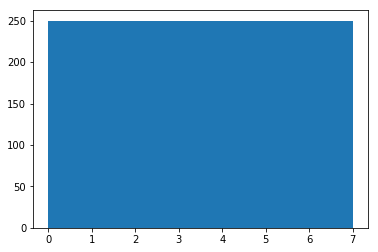

In [4]:
plt.hist(Y_train,bins=8)

(array([ 50.,  50.,  50.,  50.,  50.,  50.,  50.,  50.]),
 array([ 0.   ,  0.875,  1.75 ,  2.625,  3.5  ,  4.375,  5.25 ,  6.125,  7.   ]),
 <a list of 8 Patch objects>)

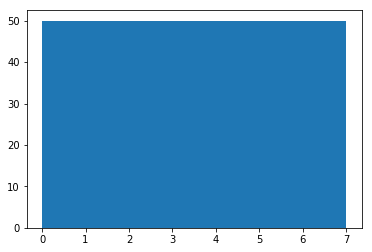

In [5]:
plt.hist(Y_valid,bins=8)

How hard is this task? Lets plot some random image of the trainset to get an impression of the images and of  the task. 

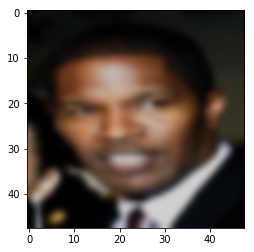

In [6]:
np.random.seed(seed=42)
rmd=np.random.randint(0,len(X_train))
plt.imshow(np.asarray(X_train[rmd],dtype="uint8"),interpolation="bicubic")

#### Normalization of the training and validationset.

In [7]:
X_mean = np.mean( X_train, axis = 0)
X_std = np.std( X_train, axis = 0)

X_train = (X_train - X_mean ) / (X_std + 0.0001)
X_valid = (X_valid - X_mean ) / (X_std + 0.0001)

#### Flattern the images into a vector because we unly use fully connected layers in this model

In [8]:
print(X_train.shape)
X_newtrain=np.zeros([len(X_train),48*48*3])
for i in range(0,len(X_train)):
    X_newtrain[i]=np.reshape(X_train[i],newshape=((48*48*3),))
    
X_newvalid=np.zeros([len(X_valid),48*48*3])
for i in range(0,len(X_valid)):
    X_newvalid[i]=np.reshape(X_valid[i],newshape=((48*48*3),))

(2000, 48, 48, 3)


In [9]:
X_newtrain.shape

(2000, 6912)

In [10]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


Define the convertToOneHot function and convert the labels into the onehot encoding.

In [11]:
def convertToOneHot(vector, num_classes=None):
    result = np.zeros((len(vector), num_classes), dtype='int32')
    result[np.arange(len(vector)), vector] = 1
    return result

In [12]:
Y_train=convertToOneHot(Y_train,num_classes=8)
Y_valid=convertToOneHot(Y_valid,num_classes=8)

In [13]:
batch_size = 128
nb_classes = 8
nb_epoch = 50

In [14]:
print(Y_train[1])
print(Y_valid[1])

[0 0 0 1 0 0 0 0]
[0 0 0 0 0 1 0 0]


In [15]:
print(X_newtrain.shape)
print(X_newvalid.shape)

(2000, 6912)
(400, 6912)


### Define the network

In [16]:
model = Sequential()
name = 'only_fc'

model.add(Dense(nb_classes,kernel_initializer='he_normal',input_dim=(48*48*3)))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [17]:
model = Sequential()
name = 'fc_with_hidden'

model.add(Dense(400,kernel_initializer='he_normal',input_dim=(48*48*3)))
model.add(Activation('relu'))

model.add(Dense(200,kernel_initializer='he_normal'))
model.add(Activation('relu'))

model.add(Dense(nb_classes,kernel_initializer='he_normal'))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 400)               2765200   
_________________________________________________________________
activation_2 (Activation)    (None, 400)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 200)               80200     
_________________________________________________________________
activation_3 (Activation)    (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 1608      
_________________________________________________________________
activation_4 (Activation)    (None, 8)                 0         
Total params: 2,847,008.0
Trainable params: 2,847,008.0
Non-trainable params: 0.0
____________________________________________________________

### Running a forward pass of the untrained network

In [19]:
model.evaluate(X_newtrain,Y_train)

1984/2000 [============================>.] - ETA: 0s 

[2.3941805248260497, 0.123]

In [20]:
-np.log(1/8)

2.0794415416798357

In [21]:
model.predict(X_newtrain[0].reshape(1,48*48*3))

array([[ 0.12015427,  0.18278927,  0.01640404,  0.07898434,  0.10452182,
         0.09316821,  0.28103676,  0.12294123]], dtype=float32)

In [22]:
tensorboard = keras.callbacks.TensorBoard(
        log_dir='tensorboard/8_faces/' + name + '/', 
        write_graph=True,
        histogram_freq=1)

### Training the network

In [23]:
history=model.fit(X_newtrain, Y_train, 
                  batch_size=batch_size, 
                  epochs=30,
                  verbose=2, 
                  validation_data=(X_newvalid, Y_valid),
                  callbacks=[tensorboard])

Train on 2000 samples, validate on 400 samples
INFO:tensorflow:Summary name dense_2/kernel:0 is illegal; using dense_2/kernel_0 instead.
INFO:tensorflow:Summary name dense_2/bias:0 is illegal; using dense_2/bias_0 instead.
INFO:tensorflow:Summary name dense_3/kernel:0 is illegal; using dense_3/kernel_0 instead.
INFO:tensorflow:Summary name dense_3/bias:0 is illegal; using dense_3/bias_0 instead.
INFO:tensorflow:Summary name dense_4/kernel:0 is illegal; using dense_4/kernel_0 instead.
INFO:tensorflow:Summary name dense_4/bias:0 is illegal; using dense_4/bias_0 instead.
Epoch 1/30
16s - loss: 3.4606 - acc: 0.2770 - val_loss: 2.5146 - val_acc: 0.3525
Epoch 2/30
16s - loss: 1.6579 - acc: 0.5110 - val_loss: 1.7322 - val_acc: 0.4950
Epoch 3/30
16s - loss: 1.0037 - acc: 0.6815 - val_loss: 1.6853 - val_acc: 0.5000
Epoch 4/30
17s - loss: 0.6271 - acc: 0.8010 - val_loss: 1.5866 - val_acc: 0.5475
Epoch 5/30
18s - loss: 0.4131 - acc: 0.8770 - val_loss: 1.5847 - val_acc: 0.5400
Epoch 6/30
17s - los

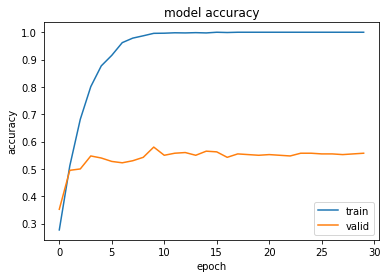

In [24]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()

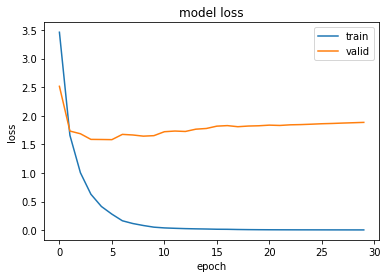

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

### Evaluation of the trained network

In [26]:
X_test = h5f_X['X_test_8_faces']
print(X_test.shape)
Y_test = h5f_X['Y_test_8_faces']
print(Y_test.shape)

(400, 48, 48, 3)
(400,)


In [27]:
X_test = (X_test - X_mean ) / (X_std + 0.0001)

In [28]:
X_newtest=np.zeros([len(X_test),48*48*3])
for i in range(0,len(X_test)):
    X_newtest[i]=np.reshape(X_test[i],newshape=((48*48*3),))

In [29]:
model.predict(X_newtest[0].reshape(1,48*48*3))

array([[  1.35860228e-06,   4.41836827e-02,   5.84317092e-03,
          4.53911051e-02,   2.95060512e-04,   6.04888948e-04,
          1.80545412e-05,   9.03662622e-01]], dtype=float32)

In [30]:
preds=np.zeros([len(X_newtest),8])
for i in range(0,len(X_newtest)):
    preds[i]=model.predict(X_newtest[i].reshape(1,48*48*3))

In [31]:
pred=np.zeros([len(X_test)])
for i in range(0,len(X_test)):
    pred[i]=np.argmax(preds[i])

In [32]:
sum(pred==Y_test)/400

0.54749999999999999

In [33]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_test, pred)

array([[32,  2,  5,  2,  2,  0,  3,  4],
       [ 3, 15,  2,  5, 11,  3,  4,  7],
       [ 2,  4, 34,  1,  1,  0,  0,  8],
       [ 6,  4,  6, 19,  5,  2,  6,  2],
       [ 0,  3,  0,  1, 39,  1,  2,  4],
       [ 3,  6,  4,  3,  3, 26,  2,  3],
       [ 3,  2,  5,  5,  3,  0, 31,  1],
       [ 5,  8,  7,  0,  2,  5,  0, 23]])